# 📊 Analisis Time Series - Prediksi Kematian Akibat Stroke

## Deskripsi Project
Notebook ini melakukan analisis time series dan prediksi kematian akibat stroke menggunakan model ARIMA. Dataset mencakup data historis dari berbagai negara dari tahun 2000-2021.

## Metodologi
1. **Data Loading & Preprocessing**: Membersihkan data, menghapus entitas agregat, dan menangani missing values
2. **Model ARIMA**: Menggunakan Auto ARIMA untuk menemukan parameter optimal (p,d,q) per negara
3. **Prediksi**: Membuat prediksi 5 tahun ke depan (2022-2026)
4. **Evaluasi**: Menghitung MAPE (Mean Absolute Percentage Error) untuk setiap negara
5. **Visualisasi**: Grafik interaktif dan perbandingan hasil

## Output yang Dihasilkan
- ✅ Dataset bersih dengan 194 negara
- ✅ Model ARIMA dengan parameter optimal per negara
- ✅ Prediksi 5 tahun (2022-2026)
- ✅ Evaluasi akurasi (MAPE)
- ✅ Visualisasi interaktif
- ✅ Tabel ringkasan perbandingan

---

In [1]:
import pandas as pd

# Load dataset utama
df = pd.read_csv('timeseries.csv')

# Rename kolom agar lebih mudah digunakan
df = df.rename(columns={
    'Entity': 'Country',
    'Total deaths from stroke among both sexes': 'Stroke_Deaths'
})

# Hapus kolom Code jika ada
if 'Code' in df.columns:
    df = df.drop(columns=['Code'])

# Tampilkan 10 baris awal
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(10)

Dataset shape: (4422, 3)

Columns: ['Country', 'Year', 'Stroke_Deaths']


,Country,Year,Stroke_Deaths
0,Afghanistan,2000,14641.85
1,Afghanistan,2001,14892.41
2,Afghanistan,2002,15578.43
3,Afghanistan,2003,16700.15
4,Afghanistan,2004,17119.86
5,Afghanistan,2005,17303.96
6,Afghanistan,2006,17496.20
7,Afghanistan,2007,17366.04
8,Afghanistan,2008,17019.65
9,Afghanistan,2009,16752.88


In [2]:
# 1. Hapus baris entitas agregat (bukan negara)
REMOVE = [
    "World", "Asia", "Africa", "Europe", "European Union",
    "North America", "South America", "Latin America and Caribbean",
    "Oceania"
]

df = df[~df['Country'].isin(REMOVE)]

# 2. Hapus duplikasi jika ada
df = df.drop_duplicates()

# 3. Tangani missing value dengan interpolasi per negara
df['Stroke_Deaths'] = df.groupby('Country')['Stroke_Deaths'] \
                        .transform(lambda x: x.interpolate(method='linear'))

# Jika masih ada NA → isi median negara
df['Stroke_Deaths'] = df.groupby('Country')['Stroke_Deaths'] \
                        .transform(lambda x: x.fillna(x.median()))

# 4. Ubah tipe data agar rapi
df['Year'] = df['Year'].astype(int)
df['Stroke_Deaths'] = df['Stroke_Deaths'].astype(float)

# 5. Sort berdasarkan negara dan tahun
df = df.sort_values(by=['Country', 'Year']).reset_index(drop=True)

# Tampilkan hasil akhir preprocessing dasar
print(f"Dataset setelah preprocessing: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nInfo statistik:")
print(df['Stroke_Deaths'].describe())
df.head(10)

Dataset setelah preprocessing: (4268, 3)
Missing values: 0

Info statistik:
count    4.268000e+03
mean     3.244200e+04
std      1.713477e+05
min      3.010000e+00
25%      9.410850e+02
50%      5.083050e+03
75%      1.489160e+04
max      2.529663e+06
Name: Stroke_Deaths, dtype: float64


,Country,Year,Stroke_Deaths
0,Afghanistan,2000,14641.85
1,Afghanistan,2001,14892.41
2,Afghanistan,2002,15578.43
3,Afghanistan,2003,16700.15
4,Afghanistan,2004,17119.86
5,Afghanistan,2005,17303.96
6,Afghanistan,2006,17496.20
7,Afghanistan,2007,17366.04
8,Afghanistan,2008,17019.65
9,Afghanistan,2009,16752.88


In [3]:
# ==========================================
# PEMBENTUKAN DATA TIME SERIES PER NEGARA
# ==========================================

# Mendapatkan daftar semua negara
list_negara = df['Country'].unique()

print("Jumlah negara:", len(list_negara))
print("\nBeberapa negara dalam dataset:")
print(list_negara[:10])

Jumlah negara: 194

Beberapa negara dalam dataset:
['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria']


In [5]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

In [7]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

def prediksi_per_negara(df, n_years=1, sample_countries=None):
    if sample_countries is not None:
        list_negara = sample_countries
    else:
        list_negara = df['Country'].unique()
    
    hasil_prediksi = []
    
    for idx, negara in enumerate(list_negara):
        print(f"Processing {idx+1}/{len(list_negara)}: {negara}")
        
        # Time series per negara
        ts = df[df['Country'] == negara].groupby('Year')['Stroke_Deaths'].sum()
        ts.index = pd.to_datetime(ts.index, format='%Y')
        
        # Auto ARIMA
        model = auto_arima(
            ts,
            seasonal=False,
            suppress_warnings=True,
            stepwise=True
        )
        
        # Ambil p,d,q
        p, d, q = model.order
        
        # Prediksi n tahun
        forecast_values = model.predict(n_periods=n_years)
        
        last_year = ts.index.year.max()
        
        # Simpan hasil
        for i in range(n_years):
            hasil_prediksi.append({
                'Country': negara,
                'Year': last_year + (i + 1),
                'Predicted_Stroke_Deaths': float(forecast_values[i]),
                'p': p,
                'd': d,
                'q': q
            })
    
    return pd.DataFrame(hasil_prediksi)

# Jalankan untuk 10 negara pertama sebagai contoh
sample_negara = list_negara[:10]
print(f"Menjalankan prediksi untuk {len(sample_negara)} negara...\n")

df_prediksi = prediksi_per_negara(df, n_years=5, sample_countries=sample_negara)
print(f"\n{'='*60}")
print("Hasil Prediksi (10 negara pertama, 5 tahun ke depan):")
print(f"{'='*60}")
df_prediksi

Menjalankan prediksi untuk 10 negara...

Processing 1/10: Afghanistan


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 2/10: Albania


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 3/10: Algeria


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 4/10: Andorra


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 5/10: Angola


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 6/10: Antigua and Barbuda


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 7/10: Argentina


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 8/10: Armenia


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 9/10: Australia


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


Processing 10/10: Austria

Hasil Prediksi (10 negara pertama, 5 tahun ke depan):

Hasil Prediksi (10 negara pertama, 5 tahun ke depan):


C:\Users\asus\AppData\Local\Temp\ipykernel_13996\2201908037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Predicted_Stroke_Deaths': float(forecast_values[i]),


,Country,Year,Predicted_Stroke_Deaths,p,d,q
0,Afghanistan,2022,20576.559524,0,1,0
1,Afghanistan,2023,20846.319048,0,1,0
2,Afghanistan,2024,21116.078571,0,1,0
3,Afghanistan,2025,21385.838095,0,1,0
4,Afghanistan,2026,21655.597619,0,1,0
5,Albania,2022,6740.090000,0,1,0
6,Albania,2023,6740.090000,0,1,0
7,Albania,2024,6740.090000,0,1,0
8,Albania,2025,6740.090000,0,1,0
9,Albania,2026,6740.090000,0,1,0


In [4]:
!pip install pmdarima


   ---------------------------------------- 0.0/715.6 kB ? eta -:--:--
   ----------------------------- ---------- 524.3/715.6 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 715.6/715.6 kB 3.6 MB/s  0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.8 MB 5.6 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 4.0 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.8 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 3.3 MB/s  0:00:00

   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
   ---------------------------------------- 0/2 [Cython]
  

In [8]:
!pip install ipywidgets


   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ---------------------------------- ----- 786.4/914.9 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 914.9/914.9 kB 3.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.2 MB 5.6 MB/s eta 0:00:01
   ---------------------------- ----------- 1.6/2.2 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 3.4 MB/s  0:00:00

   ------------- -------------------------- 1/3 [jupyterlab_widgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------

In [9]:
# ==========================================
# GRAFIK HISTORIS + PREDIKSI PER NEGARA
# ==========================================

import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import pandas as pd

# Gunakan hanya negara yang sudah diprediksi
list_negara_prediksi = sorted(df_prediksi['Country'].unique())

def plot_ts_prediksi(negara):
    
    # ============================
    # DATA HISTORIS
    # ============================
    ts_hist = df[df['Country'] == negara].groupby('Year')['Stroke_Deaths'].sum()
    years_hist = ts_hist.index
    values_hist = ts_hist.values
    
    # ============================
    # DATA PREDIKSI (semua n_years)
    # ============================
    pred_data = df_prediksi[df_prediksi['Country'] == negara]
    years_pred = pred_data['Year'].values
    values_pred = pred_data['Predicted_Stroke_Deaths'].values
    
    # Get ARIMA parameters
    arima_params = pred_data[['p', 'd', 'q']].iloc[0]
    
    # ============================
    # PLOT
    # ============================
    plt.figure(figsize=(12, 6))
    
    # Plot historis
    plt.plot(
        years_hist, values_hist,
        marker='o', linewidth=2, label="Historical", color='blue'
    )
    
    # Plot semua prediksi (misal 5 tahun)
    plt.plot(
        years_pred, values_pred,
        marker='s', linestyle='--', linewidth=2, label=f"Forecast ({len(years_pred)} years)", color='red'
    )
    
    plt.title(f"Stroke Deaths per Year — {negara}\nARIMA({arima_params['p']}, {arima_params['d']}, {arima_params['q']})", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Stroke Deaths", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

print("Visualisasi Time Series + Prediksi ARIMA")
print(f"Tersedia {len(list_negara_prediksi)} negara\n")

# Dropdown
interact(
    plot_ts_prediksi,
    negara=Dropdown(options=list_negara_prediksi, description='Country:', value=list_negara_prediksi[0])
)

Visualisasi Time Series + Prediksi ARIMA
Tersedia 10 negara



interactive(children=(Dropdown(description='Country:', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra'…

<function __main__.plot_ts_prediksi(negara)>

In [10]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

def evaluasi_mape_per_negara(df, sample_countries=None):
    if sample_countries is not None:
        list_negara = sample_countries
    else:
        list_negara = df['Country'].unique()
    
    hasil_mape = []
    
    for idx, negara in enumerate(list_negara):
        print(f"Evaluating {idx+1}/{len(list_negara)}: {negara}")
        
        # Time series per negara
        ts = df[df['Country'] == negara].groupby('Year')['Stroke_Deaths'].sum()
        ts.index = pd.to_datetime(ts.index, format='%Y')
        
        # Model ARIMA otomatis
        model = auto_arima(
            ts,
            seasonal=False,
            suppress_warnings=True,
            stepwise=True
        )
        
        # Prediksi in-sample
        pred_in_sample = model.predict_in_sample()
        
        # MAPE (0-100%)
        mape = mean_absolute_percentage_error(ts.values, pred_in_sample) * 100
        
        hasil_mape.append({
            'Country': negara,
            'MAPE (%)': round(mape, 2),
            'ARIMA_Order': f"({model.order[0]}, {model.order[1]}, {model.order[2]})"
        })
    
    return pd.DataFrame(hasil_mape)

print("Evaluasi MAPE untuk 10 negara pertama...\n")

Evaluasi MAPE untuk 10 negara pertama...



In [11]:
df_mape = evaluasi_mape_per_negara(df, sample_countries=sample_negara)

print("\n" + "="*60)
print("HASIL EVALUASI MAPE")
print("="*60)
print(f"\nRata-rata MAPE: {df_mape['MAPE (%)'].mean():.2f}%")
print(f"MAPE Terbaik: {df_mape['MAPE (%)'].min():.2f}% ({df_mape.loc[df_mape['MAPE (%)'].idxmin(), 'Country']})")
print(f"MAPE Terburuk: {df_mape['MAPE (%)'].max():.2f}% ({df_mape.loc[df_mape['MAPE (%)'].idxmax(), 'Country']})")
print("\nDetail per Negara:")
df_mape

Evaluating 1/10: Afghanistan
Evaluating 2/10: Albania
Evaluating 2/10: Albania
Evaluating 3/10: Algeria
Evaluating 3/10: Algeria
Evaluating 4/10: Andorra
Evaluating 4/10: Andorra
Evaluating 5/10: Angola
Evaluating 5/10: Angola
Evaluating 6/10: Antigua and Barbuda
Evaluating 6/10: Antigua and Barbuda
Evaluating 7/10: Argentina
Evaluating 7/10: Argentina
Evaluating 8/10: Armenia
Evaluating 8/10: Armenia
Evaluating 9/10: Australia
Evaluating 9/10: Australia
Evaluating 10/10: Austria
Evaluating 10/10: Austria

HASIL EVALUASI MAPE

Rata-rata MAPE: 8.54%
MAPE Terbaik: 5.34% (Andorra)
MAPE Terburuk: 15.16% (Albania)

Detail per Negara:

HASIL EVALUASI MAPE

Rata-rata MAPE: 8.54%
MAPE Terbaik: 5.34% (Andorra)
MAPE Terburuk: 15.16% (Albania)

Detail per Negara:


,Country,MAPE (%),ARIMA_Order
0,Afghanistan,6.35,"(0, 1, 0)"
1,Albania,15.16,"(0, 1, 0)"
2,Algeria,7.64,"(1, 2, 0)"
3,Andorra,5.34,"(1, 0, 0)"
4,Angola,7.26,"(0, 1, 0)"
5,Antigua and Barbuda,9.83,"(2, 0, 1)"
6,Argentina,8.15,"(0, 1, 0)"
7,Armenia,9.87,"(0, 1, 0)"
8,Australia,6.43,"(0, 1, 1)"
9,Austria,9.36,"(0, 1, 0)"


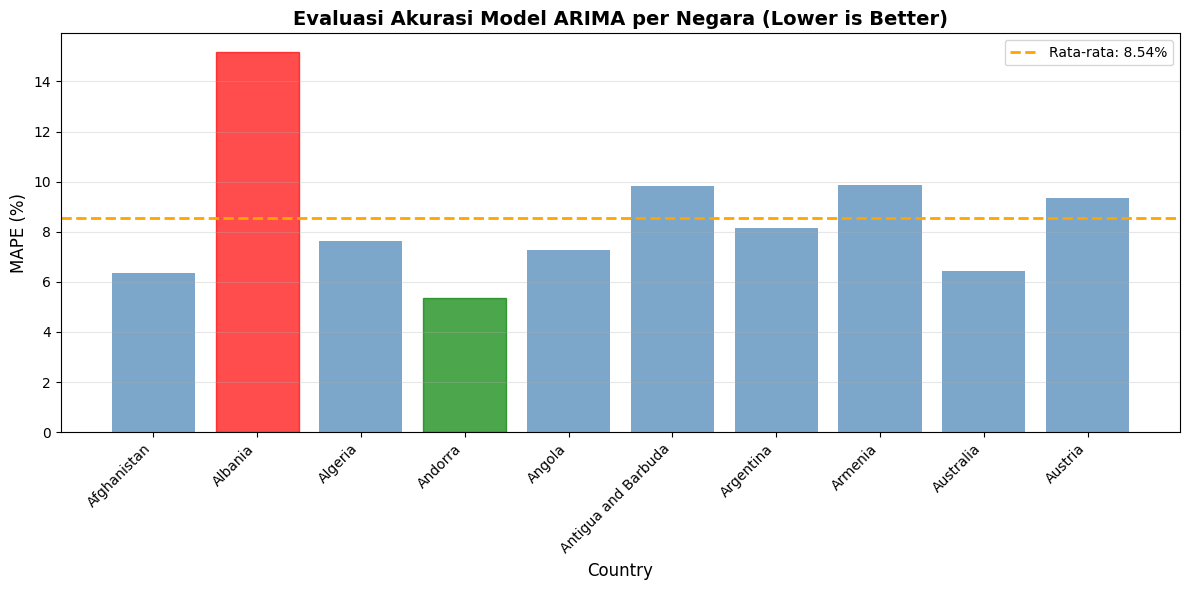

Interpretasi:
- Bar hijau: Model terbaik (MAPE terendah)
- Bar merah: Model terburuk (MAPE tertinggi)
- Garis oranye: Rata-rata MAPE


In [12]:
# Visualisasi MAPE per Negara
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart
bars = ax.bar(df_mape['Country'], df_mape['MAPE (%)'], color='steelblue', alpha=0.7)

# Highlight best and worst
best_idx = df_mape['MAPE (%)'].idxmin()
worst_idx = df_mape['MAPE (%)'].idxmax()
bars[best_idx].set_color('green')
bars[worst_idx].set_color('red')

# Add horizontal line for average
avg_mape = df_mape['MAPE (%)'].mean()
ax.axhline(y=avg_mape, color='orange', linestyle='--', linewidth=2, label=f'Rata-rata: {avg_mape:.2f}%')

ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.set_title('Evaluasi Akurasi Model ARIMA per Negara (Lower is Better)', fontsize=14, fontweight='bold')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretasi:")
print("- Bar hijau: Model terbaik (MAPE terendah)")
print("- Bar merah: Model terburuk (MAPE tertinggi)")
print("- Garis oranye: Rata-rata MAPE")

In [14]:
# Tabel Ringkasan: Nilai Aktual vs Prediksi
import pandas as pd

# Cek tahun terakhir dalam data
last_year = df['Year'].max()
print(f"Tahun terakhir dalam data: {last_year}")

# Ambil data aktual tahun terakhir
data_last = df[df['Year'] == last_year][['Country', 'Stroke_Deaths']]
data_last = data_last[data_last['Country'].isin(sample_negara)]
data_last.columns = ['Country', f'Actual_{last_year}']

# Ambil prediksi tahun pertama dan terakhir
first_pred_year = df_prediksi['Year'].min()
last_pred_year = df_prediksi['Year'].max()

pred_first = df_prediksi[df_prediksi['Year'] == first_pred_year][['Country', 'Predicted_Stroke_Deaths']]
pred_first.columns = ['Country', f'Pred_{first_pred_year}']

pred_last = df_prediksi[df_prediksi['Year'] == last_pred_year][['Country', 'Predicted_Stroke_Deaths']]
pred_last.columns = ['Country', f'Pred_{last_pred_year}']

# Gabungkan semua
summary = data_last.merge(pred_first, on='Country').merge(pred_last, on='Country')

# Hitung perubahan
col_last_year = f'Actual_{last_year}'
col_pred_last = f'Pred_{last_pred_year}'

summary['Change'] = summary[col_pred_last] - summary[col_last_year]
summary['Change_Pct (%)'] = ((summary[col_pred_last] - summary[col_last_year]) / summary[col_last_year] * 100).round(2)

# Format angka
summary[col_last_year] = summary[col_last_year].round(0).astype(int)
summary[f'Pred_{first_pred_year}'] = summary[f'Pred_{first_pred_year}'].round(0).astype(int)
summary[col_pred_last] = summary[col_pred_last].round(0).astype(int)
summary['Change'] = summary['Change'].round(0).astype(int)

print("="*100)
print(f"RINGKASAN PREDIKSI STROKE DEATHS ({last_year} → {last_pred_year})")
print("="*100)
summary

Tahun terakhir dalam data: 2021
RINGKASAN PREDIKSI STROKE DEATHS (2021 → 2026)


,Country,Actual_2021,Pred_2022,Pred_2026,Change,Change_Pct (%)
0,Afghanistan,20307,20577,21656,1349,6.64
1,Albania,6740,6740,6740,0,0.00
2,Algeria,26022,27398,32579,6556,25.20
3,Andorra,29,30,32,3,9.64
4,Angola,14847,15128,16248,1400,9.43
5,Antigua and Barbuda,41,37,49,7,17.52
6,Argentina,21675,21675,21675,0,0.00
7,Armenia,2479,2479,2479,0,0.00
8,Australia,10405,10162,9805,-600,-5.77
9,Austria,5001,4812,4056,-945,-18.90


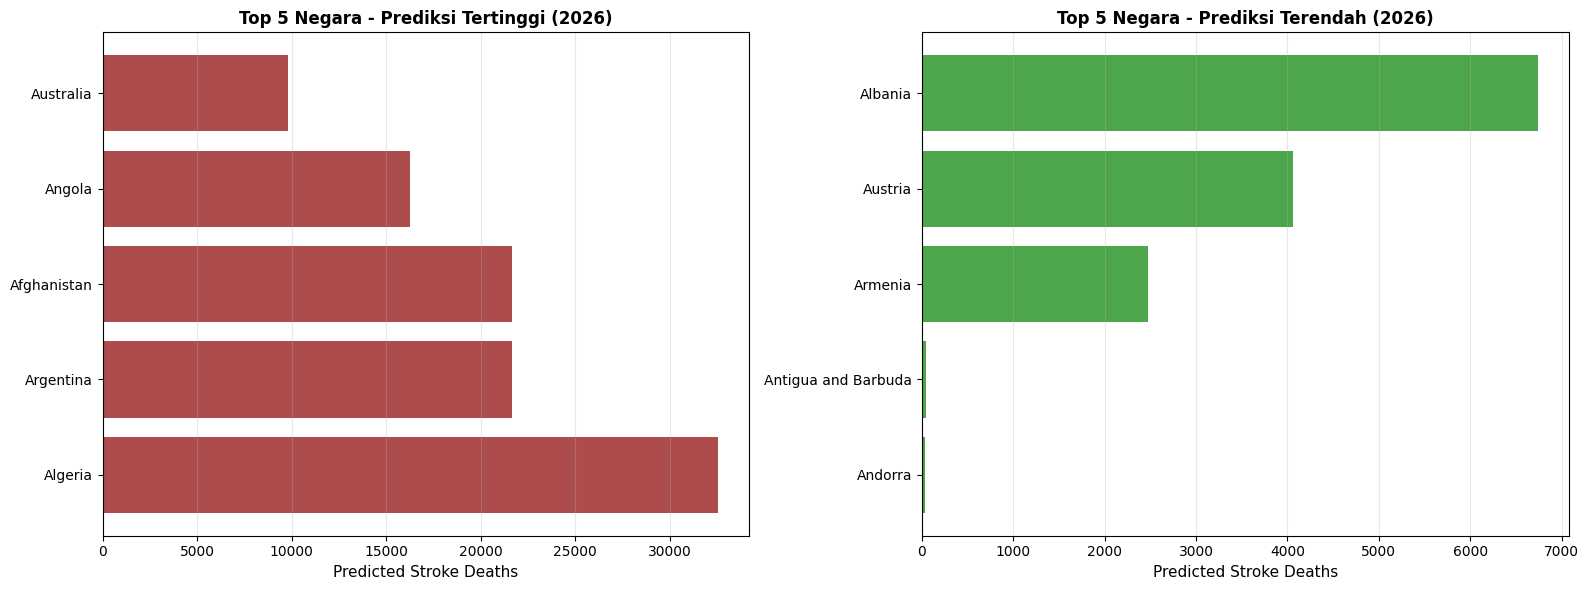


Data berdasarkan 10 negara sampel yang dianalisis
Prediksi untuk tahun 2026


In [15]:
# Visualisasi Top 5 Negara dengan Prediksi Tertinggi dan Terendah
import matplotlib.pyplot as plt

# Ambil prediksi tahun terakhir
pred_last_year = df_prediksi[df_prediksi['Year'] == df_prediksi['Year'].max()]

# Top 5 tertinggi dan terendah
top5_highest = pred_last_year.nlargest(5, 'Predicted_Stroke_Deaths')
top5_lowest = pred_last_year.nsmallest(5, 'Predicted_Stroke_Deaths')

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5 Highest
ax1.barh(top5_highest['Country'], top5_highest['Predicted_Stroke_Deaths'], color='darkred', alpha=0.7)
ax1.set_xlabel('Predicted Stroke Deaths', fontsize=11)
ax1.set_title(f'Top 5 Negara - Prediksi Tertinggi ({last_pred_year})', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Top 5 Lowest
ax2.barh(top5_lowest['Country'], top5_lowest['Predicted_Stroke_Deaths'], color='green', alpha=0.7)
ax2.set_xlabel('Predicted Stroke Deaths', fontsize=11)
ax2.set_title(f'Top 5 Negara - Prediksi Terendah ({last_pred_year})', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData berdasarkan 10 negara sampel yang dianalisis")
print(f"Prediksi untuk tahun {last_pred_year}")